In [3]:
import numpy as np
import matplotlib.pyplot as plt

## méthodes de desente, problème sans contraintes

#### 0) Fonction de Rosenbrock
On implémente la fonction de Rosenbrock qui va être testée par nos algorithmes

In [4]:
# fonction de Rosebrock
rosenbrock = lambda x: (x[0] - 1)**2 + 100*(-x[0]**2 + x[1])**2
# Gradient de la fonction de Rosebrock
grad_rosenbrock = lambda x : np.array([-400*x[0]*(-x[0]**2 + x[1]) + 2*x[0] - 2, -200*x[0]**2 + 200*x[1]])
# Hessienne de la fonction de Rosebrock
hess_rosenbrock = lambda x: np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]], [-400*x[0], 200]])

#### 1) Recherche linéaire
On commence tout d'abord par implémenter la methode de recherche linéaire (Armijo-backtracking) \
On pourra alors effectuer optionellement la recherche linéaire dans nos algorithmes

In [5]:
# Méthode de calcul du pas alpha par Armijo + Backtracking
def armijo_backtracking(func, gradfunc, descente: np.ndarray, X: np.ndarray, beta: float, alpha: float, tau: float, **kwargs):
    if(func(X + alpha*descente) > func(X) + beta*alpha*np.dot(descente, gradfunc(X))):
        return armijo_backtracking(func, gradfunc, descente, X, beta, alpha*tau, tau)
    return alpha

# On stocke cette methode linéaire dans un dictionnaire pour l'appeler dans
# nos algorithmes. 'none' correspond a un pas constant de valeur 1
methodes_recherches_lineaires = {
    'none': lambda *args, **kwargs: 1,
    'armijo_backtracking': armijo_backtracking
}

#### 2) Méthode de descente de Gradient

On implémente la méthode de descente de gradient, appliquant par défaut \
une recherche lineaire du pas avec Armijo-backtracking

In [6]:
# lors de l'appel de la fonction on pourra desactiver la recherche lineaire en 
# mettant la valeur 'none' pour le parametre 'recherche_lineraire'
def descente_de_gradient(func, gradfunc, alpha_init: float, beta: float, tau: float, X0: np.ndarray, 
                         max_iter: int = 100000, recherche_lineaire: str = 'armijo_backtracking',
                         precision: float = 1e-12,memorize: bool = False, **kwargs):
    x = X0
    if memorize:
        xlist = [X0]
    alpha = methodes_recherches_lineaires[recherche_lineaire];        
    d = -gradfunc(x)
    i = 0;    
    while (i < max_iter) and np.linalg.norm(d) > precision:            
        x = x + alpha(func, gradfunc, d, x, beta, alpha_init, tau)*d
        if memorize:
            xlist.append(x) # type: ignore
        d = -gradfunc(x)
        i +=1
    print(f'la méthode converge en {i} itérations vers {x} a la précision {precision}')
    return np.array(xlist) if memorize else x #type: ignore

In [7]:
descente_de_gradient(rosenbrock, grad_rosenbrock, alpha_init=1, beta=0.1, tau=0.3, X0=np.array([0,1]))
print('\n\n')

la méthode converge en 25705 itérations vers [1. 1.] a la précision 1e-12





#### 3) Méthode de Newton

On implémente la méthode newton, n'appliquant par défaut \
aucune recherche linéaire (pas constant = 1)

In [8]:
# **kwargs dans les paramètres permet de rajouter les paramètres alpha, tau, beta
# si on utilise la recherche linéaire. le paramètre func 
# est présent par défaut même s'il ne sert que si l'option 
# recherche_lineaire choisie est armijo-backtracking
def newton(func, gradfunc, hessfunc,X0: np.ndarray, max_iter: int =100, precision:float =1e-12,
           recherche_lineaire: str = 'none', memorize: bool = False, **kwargs):
    x = X0
    if memorize:
        xlist = [x]
    alpha = methodes_recherches_lineaires[recherche_lineaire];  
    d = -np.linalg.solve(hessfunc(x),gradfunc(x))
    i = 0
    while i < max_iter and np.linalg.norm(d) > precision:
        x = x + alpha(func, gradfunc,d,x, **kwargs)*d
        if memorize:
            xlist.append(x) # type: ignore
        d = -np.linalg.solve(hessfunc(x),gradfunc(x))
        i += 1
    print(f'la méthode converge en {i+1} itérations vers {x} a la précision {precision}')
    return np.array(xlist) if memorize else x # type: ignore

In [9]:
def compare_recherche_lineaire_pour_newton():
    print('Sans recherche linéaire:')
    newton(rosenbrock, grad_rosenbrock, hess_rosenbrock, np.array([0,1]))
    print('\nAvec recherche linéaire: ')
    newton(rosenbrock, grad_rosenbrock, hess_rosenbrock, np.array([0,1]), 
           recherche_lineaire='armijo_backtracking', 
            alpha=1, tau=0.3, beta=0.1)
    print('\n\n')

compare_recherche_lineaire_pour_newton()

Sans recherche linéaire:
la méthode converge en 7 itérations vers [1. 1.] a la précision 1e-12

Avec recherche linéaire: 
la méthode converge en 17 itérations vers [1. 1.] a la précision 1e-12





#### 4) Méthode Broyden-Fletcher-Goldfarb-Shanno (BFGS)

On implémente la methode BFGS, n'appliquant par défaut \
aucune recherche linéaire (pas constant = 1)

In [10]:
def bfgs(func, gradfunc, X0, max_iter=1000, precision: float=1e-12, 
         recherche_lineaire: str = 'none', memorize: bool = False, **kwargs):
    x = np.expand_dims(X0,1)
    if memorize:
        xlist = []
    alpha = methodes_recherches_lineaires[recherche_lineaire]
    B = np.eye(2,2)
    s = np.expand_dims(np.array([1,1]), 1)
    y = np.expand_dims(np.array([1,1]), 1)
    i = 0
    while i < max_iter and np.linalg.norm(s) >= precision:
        B = B + (1/(s.T @ y))*(y @ y.T) - (1/(s.T @ (B @ s)))*(B @ s @ s.T @ B)
        d = -np.linalg.solve(B,gradfunc(x))
        temp_x = x.copy()
        x = x + alpha(func, gradfunc, np.squeeze(d), np.squeeze(x), **kwargs)*d
        if memorize:
            xlist.append(np.squeeze(x)) # type: ignore
        s = x - temp_x
        y = gradfunc(x) - gradfunc(temp_x)
        i += 1
    x = np.squeeze(x)
    print(f'la méthode converge en {i} itérations vers {x} a la précision {precision}')
    return np.array(xlist) if memorize else x # type: ignore

In [11]:
def compare_recherche_lineaire_pour_bfgs(x0=np.array([0,1])):
    print(f'x0 = {x0}: \n')
    print('Sans recherche lineaire:')
    bfgs(rosenbrock, grad_rosenbrock, x0)
    print('\nAvec recherche lineaire: ')
    bfgs(rosenbrock, grad_rosenbrock, x0,
           recherche_lineaire='armijo_backtracking', 
            alpha=1, tau=0.3, beta=0.1)
    print('\n\n')
compare_recherche_lineaire_pour_bfgs(np.array([-1,0]))
compare_recherche_lineaire_pour_bfgs(np.array([18,3]))

x0 = [-1  0]: 

Sans recherche lineaire:
la méthode converge en 93 itérations vers [1. 1.] a la précision 1e-12

Avec recherche lineaire: 
la méthode converge en 28 itérations vers [1. 1.] a la précision 1e-12



x0 = [18  3]: 

Sans recherche lineaire:
la méthode converge en 330 itérations vers [1. 1.] a la précision 1e-12

Avec recherche lineaire: 
la méthode converge en 10 itérations vers [ 4.55295699 20.7676431 ] a la précision 1e-12





#### 5) Visualisation et comparaison graphique

On représente graphiqument les lignes de niveau de la fonction \
Rosenbrock et les itérations de chaque algorithmes

In [12]:
def graph_avec_rosenbrock(*algorithmes, max_points=100, X0=np.array([0,1])):
    fig, tot_axes = plt.subplots(nrows=len(algorithmes), ncols=2, figsize=(12,5*len(algorithmes)), squeeze=False)
    for index, axes in enumerate(tot_axes):
        axes[0].set_xlim(xmin=-1, xmax=2)
        axes[0].set_ylim(ymin=-1, ymax=2)
        xgrid,ygrid = np.meshgrid(np.linspace(-1,2,500),np.linspace(-1,2,500))
        rosenbrock_grid = rosenbrock([xgrid,ygrid])
        algo_values = algorithmes[index](func=rosenbrock, gradfunc=grad_rosenbrock, hessfunc=hess_rosenbrock,
                                X0=X0, memorize=True, max_iter=100000, precision=1e-12,
                                alpha_init=1, tau=0.3, beta=0.1)    
        axes[0].contour(xgrid,ygrid,rosenbrock_grid,[*np.linspace(0,1,10),2,20,100])
        axes[0].plot(algo_values[:,0], algo_values[:,1], 
                     label=f'solutions {algorithmes[index].__name__}', color='red')
        axes[0].set_title(f'lignes de niveaux de rosenbrock')
        axes[0].legend()
    
        min_points = min(max_points, len(algo_values))
        N = np.arange(0,min_points,1)
        axes[1].plot(N, [rosenbrock(algo_values[:min_points,:][i,:]) for i in N])
        axes[1].set_yscale('log')
        axes[1].set_title(f'rosenbrock évaluée sur les {min_points} premières itérations')

##### I) graphe de rosenbrock pour la descente de gradient

On utilise la recherche linéaire car sinon on a pas convergence  
au point (0,1)

la méthode converge en 25705 itérations vers [1. 1.] a la précision 1e-12


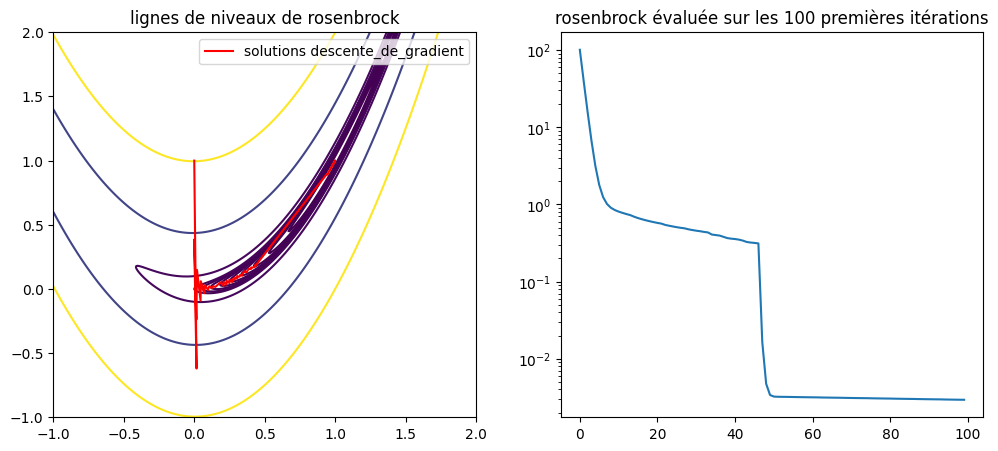

In [13]:
graph_avec_rosenbrock(descente_de_gradient)

##### II) Graphe de rosenbrock pour la méthode de newton

Sans recherche linéaire, au point (0,1)

la méthode converge en 7 itérations vers [1. 1.] a la précision 1e-12


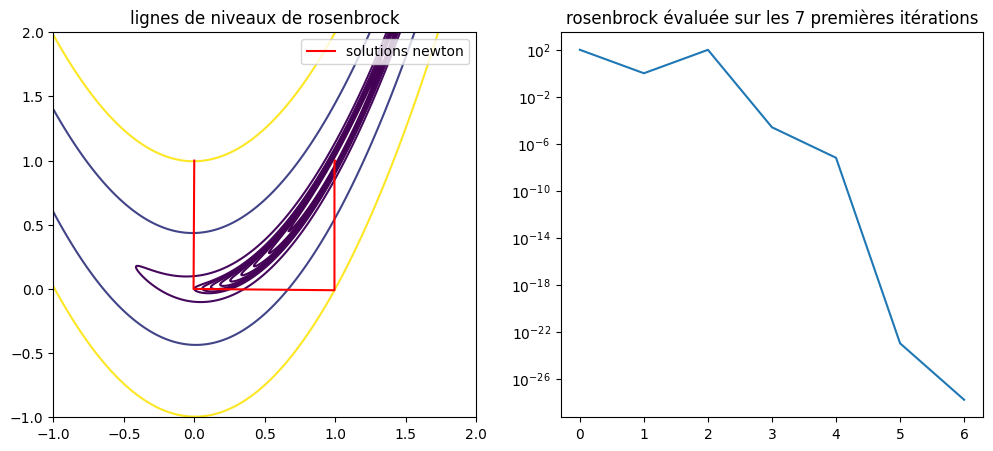

In [14]:
graph_avec_rosenbrock(newton)

##### III) Graphe de rosenbrock pour la méthode BFGS

Sans recherche linéaire, au point (0,1)

la méthode converge en 39 itérations vers [1. 1.] a la précision 1e-12


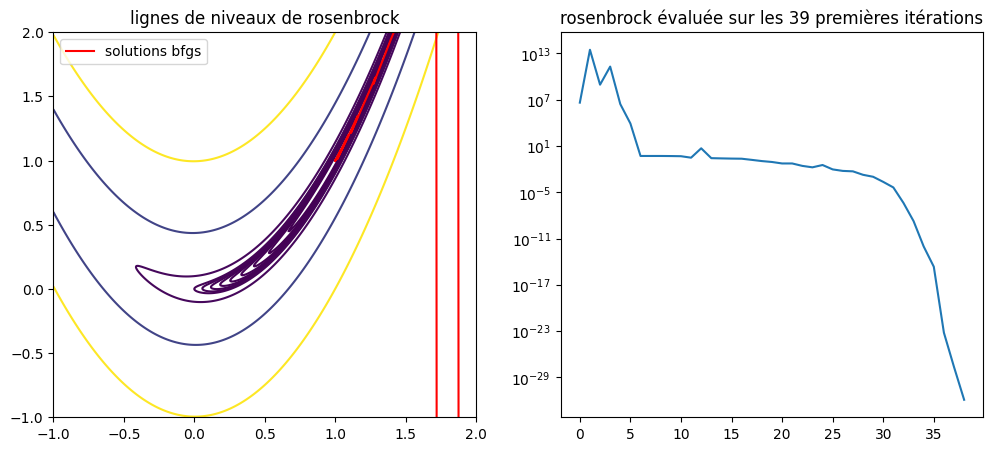

In [15]:
graph_avec_rosenbrock(bfgs)

IV) Comparaison des différents graphes

On affiche les graphes superposés pour observer les différentes vitesses de convergence.
au point (0,1)

In [16]:
def compare_graphes_avec_rosenbrock(*algorithmes, max_points=100, X0=np.array([0,1])):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    axes[0].set_xlim(xmin=-1, xmax=2)
    axes[0].set_ylim(ymin=-1, ymax=2)
    xgrid,ygrid = np.meshgrid(np.linspace(-1,2,500),np.linspace(-1,2,500))
    rosenbrock_grid = rosenbrock([xgrid,ygrid])
    for alg in algorithmes:
        algo_values = alg(func=rosenbrock, gradfunc=grad_rosenbrock, hessfunc=hess_rosenbrock,
                            X0=X0, memorize=True, max_iter=100000, precision=1e-12,
                            alpha_init=1, tau=0.3, beta=0.1) 
        axes[0].plot(algo_values[:,0], algo_values[:,1], 
                    label=f'solutions {alg.__name__}')           
        min_points = min(max_points, len(algo_values))
        N = np.arange(0,min_points,1)
        axes[1].plot(N, [rosenbrock(algo_values[:min_points,:][i,:]) for i in N],
                     label=f'{alg.__name__}')
    axes[0].contour(xgrid,ygrid,rosenbrock_grid,[*np.linspace(0,1,10),2,20,100])
    axes[0].set_title(f'lignes de niveaux de rosenbrock')
    axes[0].legend()
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].set_title(f'rosenbrock évaluée sur les {max_points} premières itérations')    

la méthode converge en 39 itérations vers [1. 1.] a la précision 1e-12
la méthode converge en 7 itérations vers [1. 1.] a la précision 1e-12
la méthode converge en 25705 itérations vers [1. 1.] a la précision 1e-12


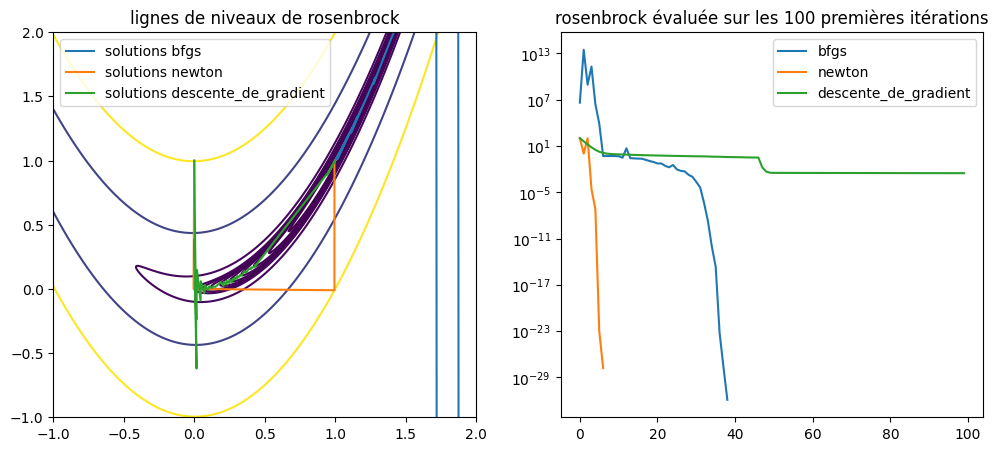

In [17]:
compare_graphes_avec_rosenbrock(bfgs, newton, descente_de_gradient, X0=np.array([0,1]))

On peut conclure que La méthode de descente de gradient converge bien, <br> 
est assez stable mais extrêmement lente (25000 itérations pour le point (0,1)). <br>
La méthode de Newton converge très vite mais est extrêmement dépendante de son <br>
point de départ. BFGS semble être un bon compromis entre rapiditié et stabilité.